In [32]:
import pandas as pd

master = pd.read_csv("../dataset/master_3.csv", encoding='utf-8')

In [33]:
master = master.drop(["intime", "outtime", "ed_los", "outcome_icu_transfer_12h"], axis='columns')

master_X = master.loc[:, master.columns!='outcome_critical']
master_Y = master['outcome_critical']

master_Y.replace([False, True],[0,1], inplace=True)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(master_X, master_Y, test_size=0.33, random_state=321)

In [35]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

In [36]:
#############--

In [37]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label=Y_train)
test_ds = lgb.Dataset(X_test, label=Y_test)

In [38]:
model_class = lgb.LGBMClassifier(boosting='goss', learning_rate=0.08, num_iterations=500, early_stopping_rounds=50,
                                 max_depth=-1,random_state=42, feature_fraction=0.8, bagging_fraction=0.7,
                                 is_training_metric=True, num_leaves=25, objective='binary', metric='bagging_fraction')
model_class.fit(X_train,Y_train,eval_set=[(X_test,Y_test),(X_train,Y_train)], verbose=20,eval_metric='logloss')

y_pred_class = model_class.predict(X_test)

C:\Users\Seok\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Seok\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[20]	training's binary_logloss: 0.126788	valid_0's binary_logloss: 0.129899
[40]	training's binary_logloss: 0.111655	valid_0's binary_logloss: 0.115273
[60]	training's binary_logloss: 0.106513	valid_0's binary_logloss: 0.110847
[80]	training's binary_logloss: 0.103879	valid_0's binary_logloss: 0.109019
[100]	training's binary_logloss: 0.102151	valid_0's binary_logloss: 0.108229
[120]	training's binary_logloss: 0.10066	valid_0's binary_logloss: 0.107718
[140]	training's binary_logloss: 0.0994025	valid_0's binary_

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def setting(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i]>=.5:       # setting threshold to .5
           y_pred[i]=1
        else:  
           y_pred[i]=0

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f},\nF1: {3: .4f}, AUC: {4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [40]:
setting(y_pred_class)
get_clf_eval(Y_test, y_pred_class)

오차 행렬
[[137023   1232]
 [  4805   5101]]
정확도:  0.9593, 정밀도:  0.8055, 재현율:  0.5149,
F1:  0.6282, AUC:  0.7530


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

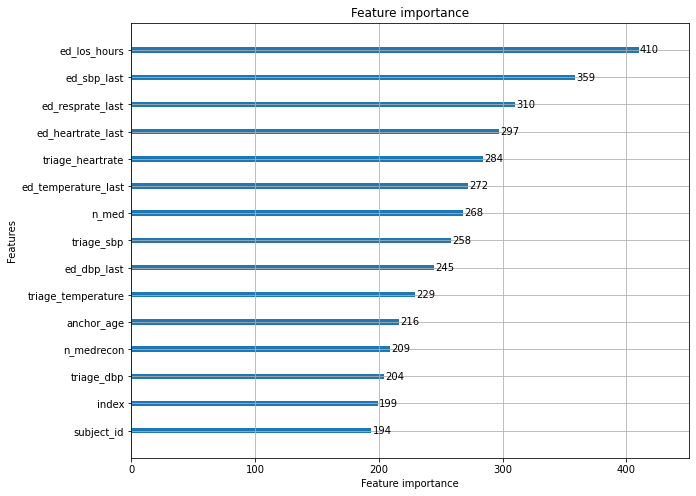

In [41]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model_class, max_num_features=15, ax=ax)